In [1]:
from abtem import __version__
print('current version:', __version__)

import matplotlib.pyplot as plt
from ase.io import read
from ase.build import mx2

from abtem import *
from abtem.structures import orthogonalize_cell



current version: 1.0.0beta22


# STEM simulation of MoS$_2$

We build an atomic structure of MoS2 with ASE. Since abTEM requires an orthogonal we make the cell orthogonal. We also need to repeat the structure, so the probe fits inside the cell.

<AxesSubplot:title={'center':'Side view'}, xlabel='x [Å]', ylabel='z [Å]'>

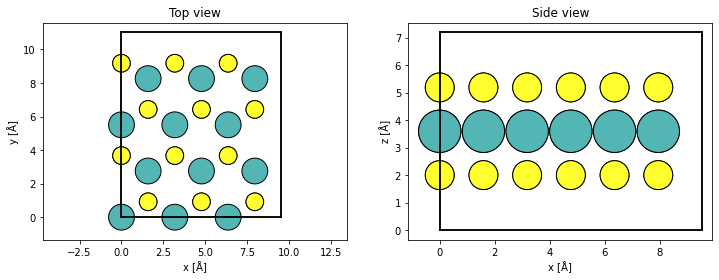

In [2]:
atoms = mx2(formula='MoS2', kind='2H', a=3.18, thickness=3.19, size=(1, 1, 1), vacuum=None)

repetitions = (3, 2, 1)

atoms = orthogonalize_cell(atoms)

atoms *= repetitions

atoms.center(vacuum=2, axis=2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

show_atoms(atoms, ax=ax1, title='Top view')
show_atoms(atoms, ax=ax2, plane='xz', title='Side view')

In [3]:
print(f"Simulation cell: {atoms.cell}")

Simulation cell: Cell([9.540000000000001, 11.01584313613806, 7.1899999999999995])


We create and calculate the electrostatic potential.

In [4]:
potential = Potential(atoms, 
                      gpts=128,
                      projection='infinite', 
                      slice_thickness=1, 
                      parametrization='kirkland')

potential = potential.build()

In [5]:
potential.compute(pbar=True)

[########################################] | 100% Completed |  0.1s


To simulate temperature effects uncomment the code below.

In [6]:
sigmas = {'Mo': .1, 'S': .1} # standard deviations of thermal vibrations
num_configs = 15 # number of frozen phonon configurations

frozen_phonons = FrozenPhonons(atoms, num_configs=num_configs, sigmas=sigmas)
potential = Potential(frozen_phonons, gpts=128, slice_thickness=1, parametrization='kirkland', projection='infinite')

In [11]:
print(f"Real space sampling: {potential.sampling}")

Real space sampling: (0.07453125000000001, 0.08606127450107859)


We create a probe with a semi-angle cutoff of 20 mrad.

In [7]:
probe = Probe(energy=80e3, semiangle_cutoff=20, rolloff=0.1, defocus=40, Cs=3e5)

To run this simulation using PRISM instead of the standard multislice algorithm, uncomment the cell below. Note that while PRISM may be up to a 1000 times faster than multislice for large structures, the performance is fairly similar for small simulations like this.

In [9]:
#probe = SMatrix(energy=80e3, semiangle_cutoff=20, expansion_cutoff=20, rolloff=0.1, defocus=40, Cs=3e5)

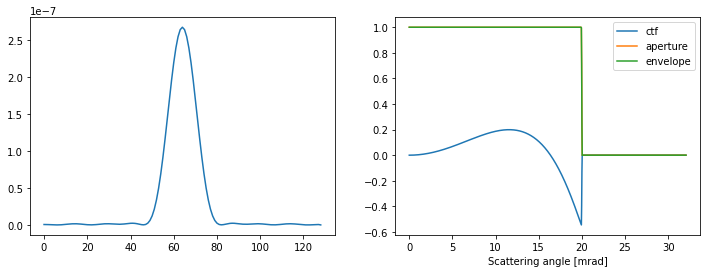

In [25]:
probe.grid.match(potential)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

probe.profile().show(ax=ax1);

probe.ctf.show(ax=ax2);

We create a `FlexibleAnnularDetector` detector which will allow us to choose the integration limits after the multislice simulation.

In [13]:
detector = FlexibleAnnularDetector(ensemble_mean=False)

We scan over one periodic unit of the potential at slightly better than the Nyquist frequency of the probe contrast transfer function.

In [18]:
end = (potential.extent[0] / repetitions[0], potential.extent[1] / repetitions[1])

gridscan = GridScan(start=[0, 0], end=end, sampling=probe.ctf.nyquist_sampling * .9)

measurement = probe.scan(gridscan, detector, potential)

#measurement.compute(pbar=True)

The output from the simulation is a `Measurement` object. This wraps a numpy array with calibrations descibing each axis. 

In our case, the first two dimensions of the numpy array scan dimenstions and the last dimension are the bins of the detector.

In [19]:
measurement.array

dask.array<radial_binning, shape=(15, 7, 12, 157, 1), dtype=float32, chunksize=(1, 7, 12, 157, 1), chunktype=numpy.ndarray>

We reduce the measurement to an image by integrating over the detector dimension taking the mean across the ensemble dimension.

In [23]:
measurement.integrate_radial(0, 20).mean(0).array

dask.array<mean_agg-aggregate, shape=(7, 12), dtype=float32, chunksize=(7, 12), chunktype=numpy.ndarray>

We can get a better view of the simulation output by tiling and interpolation the output.

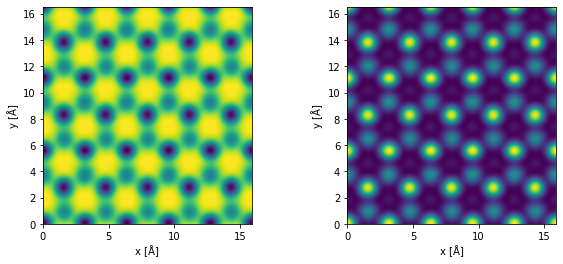

In [24]:
bright_measurement = measurement.integrate_radial(0, 20).mean(0).compute()
haadf_measurement = measurement.integrate_radial(50, 150).mean(0).compute()

interp_bright_measurement = bright_measurement.tile((5,3)).interpolate(.05)
interp_haadf_measurement = haadf_measurement.tile((5,3)).interpolate(.05)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

interp_bright_measurement.show(ax=ax1)
interp_haadf_measurement.show(ax=ax2);

The measurement object includes has a suite of tools for performing common analysis and visualization tasks.

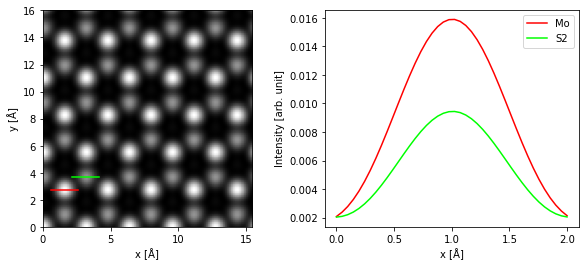

In [26]:
line1 = interp_haadf_measurement.interpolate_line(atoms[3], margin=1.)
line2 = interp_haadf_measurement.interpolate_line(atoms[16], margin=1.)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

interp_haadf_measurement.show(ax=ax1)

line1.add_to_mpl_plot(ax1, color='r')
line2.add_to_mpl_plot(ax1, color='lime')

line1.show(ax=ax2, color='r', label='Mo')
line2.show(ax=ax2, color='lime', label='S2')

ax2.set_ylabel('Intensity [arb. unit]')

ax2.legend();